In [7]:
%matplotlib inline

In [8]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit
import scipy.interpolate
import scipy.optimize
import os
import lmfit
from tqdm import tqdm
import datetime

from matplotlib import gridspec

import fit_functions
import nekhoroshev_tools

In [9]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [85]:
1 / (0.200 * np.sqrt(4.0 / 3.5))

4.677071733467426

In [64]:
def mm_to_sigma(mm):
    return mm / (0.200 * np.sqrt(4.0 / 3.5))


def mm_to_sigma_horizontal(mm):
    return mm / (0.280)


def scale_factor(vals, sigma_barrier):
    return vals / 1.8e-11


def get_roi(df, from_t, to_t):
    return df[(df["t"] >= from_t) & (df["t"] <= to_t)]

In [18]:
# read csv file
loss_1_rs9 = pd.read_csv("timber2/BLMTI.06L7.B1E10_TCP.D6L7.B1_LOSS_RS09.csv", header=1)
loss_1_rs6 = pd.read_csv("timber2/BLMTI.06L7.B1E10_TCP.D6L7.B1_LOSS_RS06.csv", header=1)
loss_1_rs4 = pd.read_csv("timber2/BLMTI.06L7.B1E10_TCP.D6L7.B1_LOSS_RS04.csv", header=1)

loss_2_rs9 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS09.csv", header=1)
loss_2_rs6 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS06.csv", header=1)
loss_2_rs4 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS04.csv", header=1)

barrier = pd.read_csv("timber/TCP.D6L7.B1_MEAS_LVDT_LU.csv", header=1)
barrier["nValue"] = mm_to_sigma(barrier["Value"])

barrier2 = pd.read_csv("timber2/TCP.C6L7.B1_MEAS_LVDT_LU.csv", header=1)
barrier2["nValue"] = mm_to_sigma(barrier2["Value"])

In [29]:
# read csv file
b2_loss_2_rs9 = pd.read_csv("timber_b2/BLMTI.06R7.B2I10_TCP.C6R7.B2_LOSS_RS09.csv", header=1)
b2_loss_2_rs6 = pd.read_csv("timber_b2/BLMTI.06R7.B2I10_TCP.C6R7.B2_LOSS_RS06.csv", header=1)
b2_loss_2_rs4 = pd.read_csv("timber_b2/BLMTI.06R7.B2I10_TCP.C6R7.B2_LOSS_RS04.csv", header=1)

b2_loss_1_rs9 = pd.read_csv("timber2_b2/BLMTI.06R7.B2I10_TCP.D6R7.B2_LOSS_RS09.csv", header=1)
b2_loss_1_rs6 = pd.read_csv("timber2_b2/BLMTI.06R7.B2I10_TCP.D6R7.B2_LOSS_RS06.csv", header=1)
b2_loss_1_rs4 = pd.read_csv("timber2_b2/BLMTI.06R7.B2I10_TCP.D6R7.B2_LOSS_RS04.csv", header=1)

b2_barrier = pd.read_csv("timber_b2/TCP.D6R7.B2_MEAS_LVDT_LU.csv", header=1)
b2_barrier["nValue"] = mm_to_sigma(b2_barrier["Value"])

b2_barrier2 = pd.read_csv("timber2_b2/TCP.C6R7.B2_MEAS_LVDT_LU.csv", header=1)
b2_barrier2["nValue"] = mm_to_sigma(b2_barrier2["Value"])

In [30]:
def utc_time_to_seconds(df):
    df["t"] = df["Timestamp (UTC_TIME)"].apply(
        lambda x: (
            datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") - datetime.datetime.strptime(loss_1_rs9["Timestamp (UTC_TIME)"].iloc[0], "%Y-%m-%d %H:%M:%S.%f")).total_seconds()
    )
    return df

In [31]:
def utc_time_to_datetime(df):
    df["datetime"] = df["Timestamp (UTC_TIME)"].apply(
        lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
    )
    return df

In [32]:
loss_1_rs9 = utc_time_to_seconds(loss_1_rs9)
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6)
loss_1_rs4 = utc_time_to_seconds(loss_1_rs4)
loss_2_rs9 = utc_time_to_seconds(loss_2_rs9)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6)
loss_2_rs4 = utc_time_to_seconds(loss_2_rs4)

barrier = utc_time_to_seconds(barrier)
barrier2 = utc_time_to_seconds(barrier2)

In [33]:
b2_loss_1_rs9

,Timestamp (UTC_TIME),Value
0,2017-08-06 05:32:39.000,3.148000e-07
1,2017-08-06 05:33:39.000,3.093000e-07
2,2017-08-06 05:34:39.000,3.066000e-07
3,2017-08-06 05:35:01.000,1.433400e-06
4,2017-08-06 05:35:03.000,5.938000e-07
...,...,...
38368,2017-08-07 00:10:57.000,9.860000e-07
38369,2017-08-07 00:11:57.000,9.666000e-07
38370,2017-08-07 00:12:57.000,1.008100e-06
38371,2017-08-07 00:13:57.000,9.970000e-07


In [34]:
b2_loss_1_rs9 = utc_time_to_seconds(b2_loss_1_rs9)
b2_loss_1_rs6 = utc_time_to_seconds(b2_loss_1_rs6)
b2_loss_1_rs4 = utc_time_to_seconds(b2_loss_1_rs4)
b2_loss_2_rs9 = utc_time_to_seconds(b2_loss_2_rs9)
b2_loss_2_rs6 = utc_time_to_seconds(b2_loss_2_rs6)
b2_loss_2_rs4 = utc_time_to_seconds(b2_loss_2_rs4)

b2_barrier = utc_time_to_seconds(b2_barrier)
b2_barrier2 = utc_time_to_seconds(b2_barrier2)

In [35]:
loss_1_rs9 = utc_time_to_datetime(loss_1_rs9)
loss_1_rs6 = utc_time_to_datetime(loss_1_rs6)
loss_1_rs4 = utc_time_to_datetime(loss_1_rs4)
loss_2_rs9 = utc_time_to_datetime(loss_2_rs9)
loss_2_rs6 = utc_time_to_datetime(loss_2_rs6)
loss_2_rs4 = utc_time_to_datetime(loss_2_rs4)

barrier = utc_time_to_datetime(barrier)
barrier2 = utc_time_to_datetime(barrier2)

In [36]:
b2_loss_1_rs9 = utc_time_to_datetime(b2_loss_1_rs9)
b2_loss_1_rs6 = utc_time_to_datetime(b2_loss_1_rs6)
b2_loss_1_rs4 = utc_time_to_datetime(b2_loss_1_rs4)
b2_loss_2_rs9 = utc_time_to_datetime(b2_loss_2_rs9)
b2_loss_2_rs6 = utc_time_to_datetime(b2_loss_2_rs6)
b2_loss_2_rs4 = utc_time_to_datetime(b2_loss_2_rs4)

b2_barrier = utc_time_to_datetime(b2_barrier)
b2_barrier2 = utc_time_to_datetime(b2_barrier2)

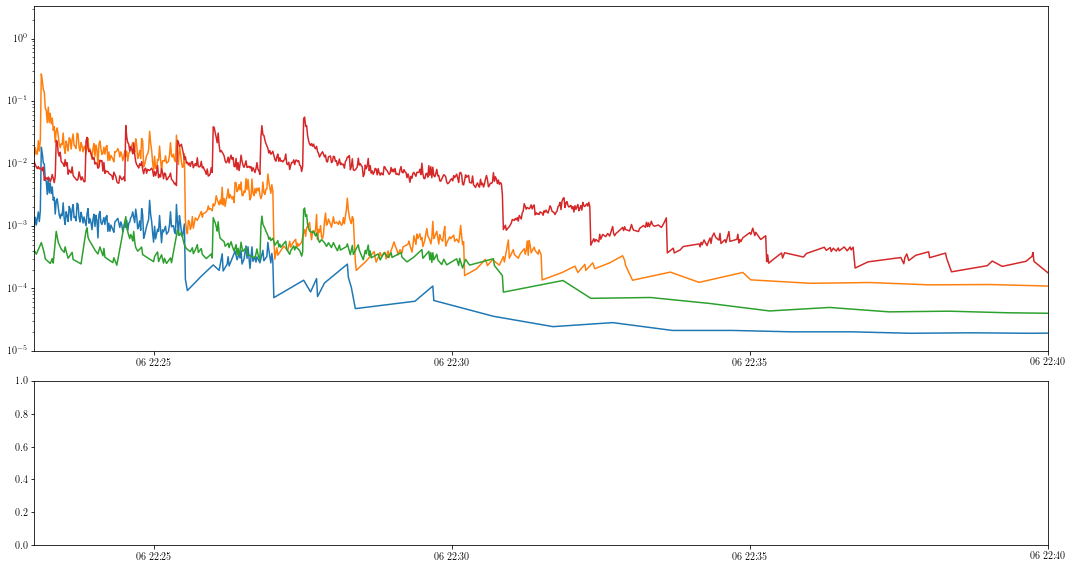

In [37]:
fig = plt.figure(figsize=(15, 8))

gs = gridspec.GridSpec(2, 1, height_ratios=[2.1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

ax0.plot(loss_1_rs6["datetime"], loss_1_rs6["Value"], label="RS6")
ax0.plot(loss_2_rs6["datetime"], loss_2_rs6["Value"], label="RS6")

ax0.plot(b2_loss_1_rs6["datetime"], b2_loss_1_rs6["Value"], label="RS6")
ax0.plot(b2_loss_2_rs6["datetime"], b2_loss_2_rs6["Value"], label="RS6")

ax0.set_yscale("log")
ax0.set_ylim(1e-5)

# ax1.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

# b_func = scipy.interpolate.interp1d(
#     barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
# )
# ax1.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

# ax1.scatter(barrier2["t"], barrier2["Value"], label="Barrier", color="black")

# b_func = scipy.interpolate.interp1d(
#     barrier2["t"], barrier2["Value"], kind="previous", fill_value="extrapolate"
# )
# ax1.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

# ax1.set_ylim(3.5, 10.0)
ax1.set_xlim(datetime.datetime(2017, 8, 6, 22, 23), datetime.datetime(2017, 8, 6, 22, 40))

plt.tight_layout()
# plt.setp(ax0.get_xticklabels(), visible=False)
# plt.subplots_adjust(hspace=.0)

In [38]:
b2_barrier2

,Timestamp (UTC_TIME),Value,nValue,t,datetime
0,2017-08-06 05:39:04.876,6.4352,30.097892,406.876,2017-08-06 05:39:04.876
1,2017-08-06 05:39:14.876,6.4362,30.102569,416.876,2017-08-06 05:39:14.876
2,2017-08-06 05:58:30.934,6.4372,30.107246,1572.934,2017-08-06 05:58:30.934
3,2017-08-06 05:58:34.934,6.4362,30.102569,1576.934,2017-08-06 05:58:34.934
4,2017-08-06 05:59:25.939,6.4351,30.097424,1627.939,2017-08-06 05:59:25.939
...,...,...,...,...,...
2008,2017-08-07 00:13:40.371,24.9951,116.903876,67282.371,2017-08-07 00:13:40.371
2009,2017-08-07 00:13:58.374,24.9940,116.898731,67300.374,2017-08-07 00:13:58.374
2010,2017-08-07 00:14:22.374,24.9929,116.893586,67324.374,2017-08-07 00:14:22.374
2011,2017-08-07 00:14:46.376,24.9939,116.898263,67348.376,2017-08-07 00:14:46.376


In [39]:
roi_1_begin = datetime.datetime(2017, 8, 6, 21, 30)
roi_1_end = datetime.datetime(2017, 8, 6, 22, 5)

roi_2_begin = datetime.datetime(2017, 8, 6, 22, 23)
roi_2_end = datetime.datetime(2017, 8, 6, 22, 40)

ratio_1 = (roi_1_end - roi_1_begin).total_seconds()
ratio_2 = (roi_2_end - roi_2_begin).total_seconds()

linspace_1 = pd.date_range(start=roi_1_begin, end=roi_1_end, periods=1000)
linspace_2 = pd.date_range(start=roi_2_begin, end=roi_2_end, periods=1000)

global_datetime = pd.date_range(
    start=loss_1_rs9["datetime"].min(), end=loss_1_rs9["datetime"].max(), periods=100000
)
global_t = np.linspace(
    loss_1_rs9["t"].min(), loss_1_rs9["t"].max(), num=100000, endpoint=True
)

In [40]:
pd.date_range(start=roi_1_begin, end=roi_1_end, periods=5)

DatetimeIndex(['2017-08-06 21:30:00', '2017-08-06 21:38:45',
               '2017-08-06 21:47:30', '2017-08-06 21:56:15',
               '2017-08-06 22:05:00'],
              dtype='datetime64[ns]', freq=None)

In [41]:
b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
b_func_2 = scipy.interpolate.interp1d(
    barrier2["t"], barrier2["Value"], kind="previous", fill_value="extrapolate"
)
b2_b_func = scipy.interpolate.interp1d(
    b2_barrier["t"], b2_barrier["Value"], kind="previous", fill_value="extrapolate"
)
b2_b_func_2 = scipy.interpolate.interp1d(
    b2_barrier2["t"], b2_barrier2["Value"], kind="previous", fill_value="extrapolate"
)

def get_idx_vals(df, func):
    diffs = np.diff(func(df["t"]))
    idxs = np.where(diffs > 0.01)[0]
    vals = df["datetime"].iloc[np.where(diffs > 0.01 / 4.7)]
    return idxs, vals

In [42]:
idx_loss_1_rs9, vals_loss_1_rs9 = get_idx_vals(loss_1_rs9, b_func)
idx_loss_2_rs9, vals_loss_2_rs9 = get_idx_vals(loss_2_rs9, b_func_2)

b2_idx_loss_1_rs9, b2_vals_loss_1_rs9 = get_idx_vals(b2_loss_1_rs9, b2_b_func)
b2_idx_loss_2_rs9, b2_vals_loss_2_rs9 = get_idx_vals(b2_loss_2_rs9, b2_b_func_2)

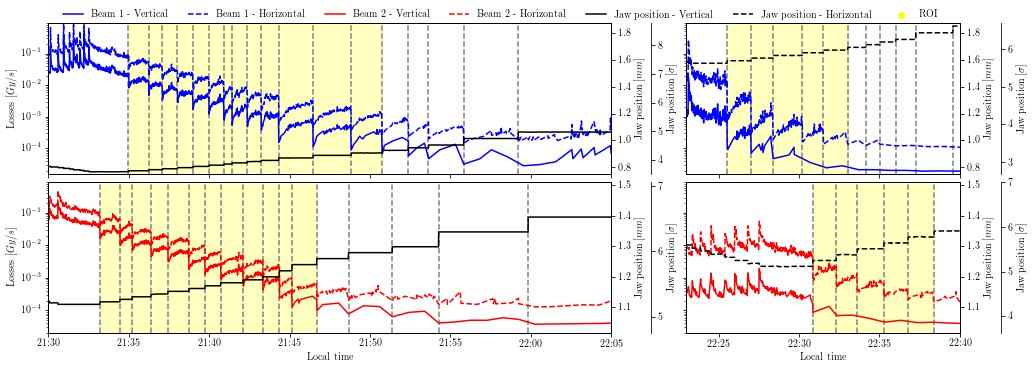

In [121]:
fig = plt.figure(figsize=(14, 5))

gs = gridspec.GridSpec(2, 2, width_ratios=[ratio_1, ratio_2])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharey=ax0)

ax2 = plt.subplot(gs[2], sharex=ax0)
ax3 = plt.subplot(gs[3], sharey=ax2, sharex=ax1)

ax0_bis = ax0.twinx()
ax1_bis = ax1.twinx()
ax0_bis.get_shared_y_axes().join(ax0_bis, ax1_bis)
ax2_bis = ax2.twinx()
ax3_bis = ax3.twinx()
ax2_bis.get_shared_y_axes().join(ax2_bis, ax3_bis)

ax0_ter = ax0.twinx()
ax1_ter = ax1.twinx()
ax2_ter = ax2.twinx()
ax3_ter = ax3.twinx()

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
ax0_bis.plot(global_datetime, b_func(global_t), label="Jaw position - Vertical", color="black")
# ax0_bis.set_ylim(3.5, 5.1)
ax0_bis.set_ylim(3.5 / 4.7, 8.81 / 4.7)
ax0_ter.set_ylim(mm_to_sigma(3.5 / 4.7), mm_to_sigma(8.81 / 4.7))
ax1_ter.set_ylim(mm_to_sigma_horizontal(3.5 / 4.7), mm_to_sigma_horizontal(8.81 / 4.7))

b_func = scipy.interpolate.interp1d(
    barrier2["t"], barrier2["Value"], kind="previous", fill_value="extrapolate"
)
ax1_bis.plot(global_datetime, b_func(global_t), color="black", label="Jaw position - Horizontal", linestyle="--")
# ax1_bis.set_ylim(7.25, 8.81)


b_func = scipy.interpolate.interp1d(
    b2_barrier["t"], b2_barrier["Value"], kind="previous", fill_value="extrapolate"
)
ax2_bis.plot(global_datetime, b_func(global_t), color="black")
ax2_bis.set_ylim(4.77 / 4.7, 7.1 / 4.7)
ax2_ter.set_ylim(mm_to_sigma(4.77 / 4.7), mm_to_sigma(7.1 / 4.7))
ax3_ter.set_ylim(mm_to_sigma_horizontal(4.77 / 4.7), mm_to_sigma_horizontal(7.1 / 4.7))

b_func = scipy.interpolate.interp1d(
    b2_barrier2["t"], b2_barrier2["Value"], kind="previous", fill_value="extrapolate"
)
ax3_bis.plot(global_datetime, b_func(global_t), color="black", linestyle="--")
# ax3_bis.set_ylim(5.7, 6.6)


for i, v in enumerate(vals_loss_1_rs9):
    color = "grey" if i != 0 and i != 13 else "grey"
    ax0.axvline(v, color=color, linestyle="--")

ax0.fill_between(
    [vals_loss_1_rs9.iloc[0], vals_loss_1_rs9.iloc[13]],
    1.5e-5,
    1.1e1,
    color="yellow",
    alpha=0.25
)

for i, v in enumerate(vals_loss_2_rs9):
    color = "grey" if i != 36 and i != 41 else "grey"
    ax1.axvline(v, color=color, linestyle="--")

ax1.fill_between(
    [vals_loss_2_rs9.iloc[36], vals_loss_2_rs9.iloc[41]],
    1.5e-5,
    1.1e1,
    color="yellow",
    alpha=0.25
)

for i, v in enumerate(b2_vals_loss_1_rs9):
    color = "grey" if i != 0 and i != 12 else "grey"
    if i==13:
        continue
    ax2.axvline(v, color=color, linestyle="--")

ax2.fill_between(
    [b2_vals_loss_1_rs9.iloc[0], b2_vals_loss_1_rs9.iloc[12]],
    1.5e-5,
    1.1e1,
    color="yellow",
    alpha=0.25
)

for i, v in enumerate(b2_vals_loss_2_rs9):
    color = "grey" if i != 2 and i != 7 else "grey"
    ax3.axvline(v, color=color, linestyle="--")

ax3.fill_between(
    [b2_vals_loss_2_rs9.iloc[2], b2_vals_loss_2_rs9.iloc[7]],
    1.5e-5,
    1.1e1,
    color="yellow",
    alpha=0.25
)

ax0.plot(loss_1_rs6["datetime"], loss_1_rs6["Value"], label="Beam 1 - Vertical", color="Blue")
ax0.plot(loss_2_rs6["datetime"], loss_2_rs6["Value"], label="Beam 1 - Horizontal", color="Blue", linestyle="--")

ax2.plot(b2_loss_1_rs6["datetime"], b2_loss_1_rs6["Value"], label="Beam 2 - Vertical", color="Red")
ax2.plot(b2_loss_2_rs6["datetime"], b2_loss_2_rs6["Value"], label="Beam 2 - Horizontal", color="Red", linestyle="--")

ax1.plot(loss_1_rs6["datetime"], loss_1_rs6["Value"], color="Blue")
ax1.plot(loss_2_rs6["datetime"], loss_2_rs6["Value"], color="Blue", linestyle="--")

ax3.plot(b2_loss_1_rs6["datetime"], b2_loss_1_rs6["Value"], color="Red")
ax3.plot(b2_loss_2_rs6["datetime"], b2_loss_2_rs6["Value"], color="Red", linestyle="--")

ax0.set_yscale("log")
ax0.set_ylim(1.5e-5, 0.9e0)

ax2.set_yscale("log")
ax2.set_ylim(2e-5, 0.9e0)

ax0.set_xlim(roi_1_begin, roi_1_end)
ax1.set_xlim(roi_2_begin, roi_2_end)

# display hours and minutes in xlabels
plt.rcParams["date.autoformatter.minute"] = "%H:%M"

ax2.set_xlabel("Local time")
ax3.set_xlabel("Local time")
ax2.set_ylabel("Losses $[Gy/s]$")
ax0.set_ylabel("Losses $[Gy/s]$")

ax1_bis.set_ylabel("Jaw position $[mm]$")
ax0_bis.set_ylabel("Jaw position $[mm]$")
ax3_bis.set_ylabel("Jaw position $[mm]$")
ax2_bis.set_ylabel("Jaw position $[mm]$")

ax1_ter.set_ylabel("Jaw position $[\\sigma]$")
ax0_ter.set_ylabel("Jaw position $[\\sigma]$")
ax3_ter.set_ylabel("Jaw position $[\\sigma]$")
ax2_ter.set_ylabel("Jaw position $[\\sigma]$")

ax3_ter.scatter([0], [0], label="ROI", color="yellow")

fig.legend(bbox_to_anchor =(0.5, 1.03), loc='upper center', ncol=12, frameon=False)

ax2_ter.yaxis.set_ticks([5.0, 6.0, 7.0])
ax3_ter.yaxis.set_ticks([4.0, 5.0, 6.0, 7.0])


#fig.autofmt_xdate(rotation=45)

plt.tight_layout()
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.setp(ax1.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

plt.subplots_adjust(hspace=.05)
plt.subplots_adjust(wspace=.18)

ax0_ter.spines["right"].set_position(("axes", 1.07))
ax2_ter.spines["right"].set_position(("axes", 1.07))
ax1_ter.spines["right"].set_position(("axes", 1.15))
ax3_ter.spines["right"].set_position(("axes", 1.15))

plt.savefig("ipac_plots/first.pdf", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.savefig("ipac_plots/first.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.savefig("ipac_plots/first.jpg", bbox_inches="tight", pad_inches=0.1, dpi=300)

In [105]:
vals_loss_2_rs9.iloc[36:]

59757   2017-08-06 22:25:32
59845   2017-08-06 22:27:01
59926   2017-08-06 22:28:23
60030   2017-08-06 22:30:12
60101   2017-08-06 22:31:30
60176   2017-08-06 22:33:01
60224   2017-08-06 22:34:08
60260   2017-08-06 22:35:01
60296   2017-08-06 22:36:00
60329   2017-08-06 22:37:15
60362   2017-08-06 22:39:34
60404   2017-08-06 22:42:03
60495   2017-08-06 22:47:22
64718   2017-08-07 00:11:31
Name: datetime, dtype: datetime64[ns]

In [3]:
def scale_factor(sigma_barrier, scenario="3.2"):
    if scenario=="1":
        F = 1.5e-13
    if scenario=="2":
        m = -97e-15
        q = 5.8e-13
        F = m * sigma_barrier + q
    if scenario=="3.1":
        m = -82e-15
        q = 5.2e-13
        F = m * sigma_barrier + q
    if scenario=="3.2":
        m = -97e-15
        q = 6.2e-13
        F = m * sigma_barrier + q
    return F


In [6]:
print(scale_factor(3.0, "1"), scale_factor(4.0, "1"))
print(scale_factor(3.0, "2"), scale_factor(4.0, "2"))
print(scale_factor(3.0, "3.1"), scale_factor(4.0, "3.1"))
print(scale_factor(3.0, "3.2"), scale_factor(4.0, "3.2"))

print(scale_factor(6.0, "1"))
print(scale_factor(6.0, "2"))
print(scale_factor(6.0, "3.1"))
print(scale_factor(6.0, "3.2"))

1.5e-13 1.5e-13
2.8899999999999993e-13 1.9199999999999994e-13
2.74e-13 1.92e-13
3.2899999999999996e-13 2.3199999999999997e-13
1.5e-13
-2.0000000000000925e-15
2.7999999999999982e-14
3.799999999999994e-14
